In [1]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib import cm
import time

import sklearn.preprocessing

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import RidgeClassifier, LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Lasso

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [58]:
# we will substract 3000 rows on beginning
data = pd.read_csv("atp.csv")
Y = pd.DataFrame(data['target'][3000:]).reset_index(drop=True)
X = data.drop(['target'], axis = 1)[3000:].reset_index(drop=True)
y = np.asarray(Y).ravel()

48711


### scalers

In [3]:
standard_scaler = sklearn.preprocessing.StandardScaler()
X_std = pd.DataFrame(standard_scaler.fit_transform(X), columns = X.columns)

### cross validation with chronological data

In [4]:
ts_cv = TimeSeriesSplit(gap=0, max_train_size=20000, n_splits=4, test_size=4000)
for train_index, test_index in ts_cv.split(X_std.iloc[:-10000]):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_std.iloc[train_index], X_std.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [ 2711  2712  2713 ... 22708 22709 22710] TEST: [22711 22712 22713 ... 26708 26709 26710]
TRAIN: [ 6711  6712  6713 ... 26708 26709 26710] TEST: [26711 26712 26713 ... 30708 30709 30710]
TRAIN: [10711 10712 10713 ... 30708 30709 30710] TEST: [30711 30712 30713 ... 34708 34709 34710]
TRAIN: [14711 14712 14713 ... 34708 34709 34710] TEST: [34711 34712 34713 ... 38708 38709 38710]


## try raw models

In [5]:
# for tuning purposes we will change ts_cv for this part of code
ts_cv = TimeSeriesSplit(gap=0, max_train_size=15000, n_splits=4, test_size=3000)
classifiers = {
    'Ridge Classifier' : RidgeClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'Gradient Boosting' : GradientBoostingClassifier(),
    'Logistic Regression' : LogisticRegression(max_iter=1000),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='rmse'),
    'Naive Bayes' : GaussianNB(),
    'Decision Tree' : DecisionTreeClassifier(),
    'k Nearest Neighbors' : KNeighborsClassifier(),
    'AdaBoost' : AdaBoostClassifier(),
    'Neural Net' :  MLPClassifier(max_iter=1000),
    "QDA" : QuadraticDiscriminantAnalysis(),
    "SVM" : SVC(),
    #"Lasso" : Lasso()
}
clf_acc = {}
clf_scores = {}

In [6]:
for name, classifier in classifiers.items():
    print("Evaluating...",name)
    scores = cross_val_score(classifier, X_std[-25000:-10000], y[-25000:-10000], cv=ts_cv, n_jobs=-1)
    clf_scores[name] = scores
    print(f'accuracy {scores.mean():.4f} with a standard deviation of {scores.std():.2f}')
    clf_acc[name] = scores.mean()

Evaluating... Ridge Classifier
accuracy 0.7747 with a standard deviation of 0.01
Evaluating... Random Forest
accuracy 0.7810 with a standard deviation of 0.01
Evaluating... Gradient Boosting
accuracy 0.8403 with a standard deviation of 0.02
Evaluating... Logistic Regression
accuracy 0.7747 with a standard deviation of 0.02
Evaluating... XGBoost
accuracy 0.8903 with a standard deviation of 0.02
Evaluating... Naive Bayes
accuracy 0.7013 with a standard deviation of 0.01
Evaluating... Decision Tree
accuracy 0.7835 with a standard deviation of 0.01
Evaluating... k Nearest Neighbors
accuracy 0.6733 with a standard deviation of 0.00
Evaluating... AdaBoost
accuracy 0.8002 with a standard deviation of 0.01
Evaluating... Neural Net
accuracy 0.8504 with a standard deviation of 0.04
Evaluating... QDA
accuracy 0.9746 with a standard deviation of 0.01
Evaluating... SVM
accuracy 0.7794 with a standard deviation of 0.02


# PCA and intuitions

In [7]:
def plot_pca_spectrum(X, search):
    print("Best n parameter pca : %d (CV mean score=%0.3f):" % (search.best_estimator_.named_steps["pca"].n_components, search.best_score_))
    # Plot the PCA spectrum
    pca = PCA()
    pca.fit(X)

    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
    
    ax0.plot(
        np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
    )
    ax0.set_ylabel("PCA explained variance ratio")

    ax0.axvline(
        search.best_estimator_.named_steps["pca"].n_components,
        linestyle=":",
        label="n_components chosen",
    )
    ax0.legend(prop=dict(size=12))

    # For each number of components, find the best classifier results
    results = pd.DataFrame(search.cv_results_)
    components_col = "param_pca__n_components"
    best_clfs = results.groupby(components_col).apply(
        lambda g: g.nlargest(1, "mean_test_score")
    )

    best_clfs.plot(
        x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
    )
    ax1.plot(
        
    )
    ax1.set_ylabel("Classification accuracy (val)")
    ax1.set_xlabel("n_components")

    plt.xlim(-1, pca.n_components_ + 1)

    plt.tight_layout()
    plt.show()

### Logistic Regression

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best n parameter pca : 220 (CV mean score=0.780):


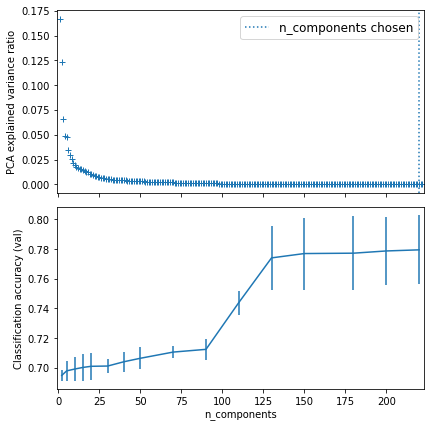

In [8]:
pca = PCA()
classifier = LogisticRegression(max_iter=1000)
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param_grid = {
    "pca__n_components": [2,5,10,15,20,30,40,50,70,90,110,130,150,180,200,220]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=2, cv = ts_cv)
search.fit(X_std[:-10000], y[:-10000])

plot_pca_spectrum(X_std[:-10000], search)

### K nearest neighb

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Best n parameter pca : 180 (CV mean score=0.676):


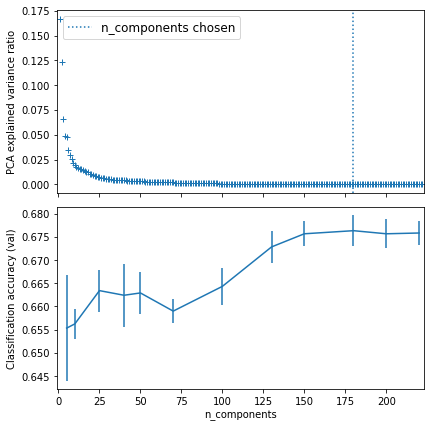

In [9]:
pca = PCA()
classifier = KNeighborsClassifier()
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param_grid = {
    "pca__n_components" : [5,10,25,40,50,70,100,130,150,180,200,220]
}
search = GridSearchCV(pipe, param_grid, n_jobs=2, verbose=2, cv = ts_cv)
search.fit(X_std[:-10000], y[:-10000])

plot_pca_spectrum(X_std[:-10000], search)

### Ridge Classifier

Fitting 4 folds for each of 16 candidates, totalling 64 fits
Best n parameter pca : 150 (CV mean score=0.786):


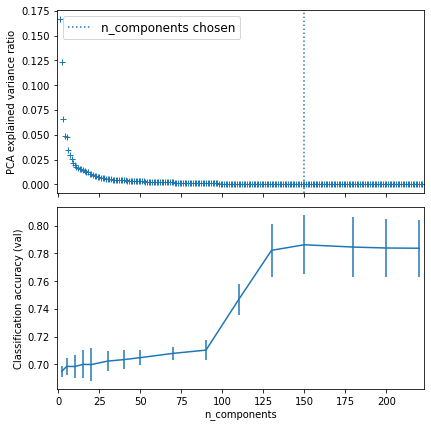

In [10]:
pca = PCA()
classifier = RidgeClassifier()
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param_grid = {
    "pca__n_components": [2,5,10,15,20,30,40,50,70,90,110,130,150,180,200,220]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=2, cv = ts_cv)
search.fit(X_std[:-10000], y[:-10000])

plot_pca_spectrum(X_std[:-10000], search)

# Hyperparameter tuning

Tree based classifiers are sensitive to data rotation. After experiments, we concluded it would be better not to apply PCA to our Tree classifiers.

In [11]:
tuned_clf = {}
best_parameters = {}
hyper_param = {}
def tune_hyperparameters(X, Y, param, pipe, n_jobs_=-1, verbose_=2):
    search = GridSearchCV(pipe, param, n_jobs=n_jobs_, verbose=verbose_, cv = ts_cv)
    search.fit(X,Y)
    return search
def analyse_params(name, classifier):
    print(name, "tuning... ", end='')
    pipe, param,n_jobs = hyper_param[name]
    start_time = time.time()
    search = tune_hyperparameters(X_std[-25000:-10000], y[-25000:-10000], param, pipe, n_jobs_=n_jobs)
    print(f'{time.time() - start_time:.3f} seconds')
    print(f"new score: {search.best_score_:.4f}  |  old score: {clf_acc[name]}  |   params: {search.best_params_}\n")
    tuned_clf[name] = search.best_estimator_
    best_parameters[name] = search.best_params_
    #clf_acc[name] = search.best_score_

In [12]:
#Ridge Classifier
n_jobs=-1
pca = PCA()
classifier = RidgeClassifier()
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param = {
    "pca__n_components": [5,10,30,70,130,140,150,160,180,190,200,210,220,222],
    "classifier__alpha": [5.0,6.0,7.0,8.0]
}
hyper_param['Ridge Classifier'] = (pipe, param,n_jobs)
analyse_params('Ridge Classifier', classifiers['Ridge Classifier'])

Ridge Classifier tuning... Fitting 4 folds for each of 56 candidates, totalling 224 fits
54.753 seconds
new score: 0.7814  |  old score: 0.7746666666666666  |   params: {'classifier__alpha': 7.0, 'pca__n_components': 150}



In [13]:
#Random Forest
n_jobs=-1
classifier = RandomForestClassifier()
pipe = Pipeline([("classifier", classifier)])
param = {
    "classifier__n_estimators" : [100],
    "classifier__max_features" : [30,80,100,130]
}
hyper_param['Random Forest'] = (pipe, param,n_jobs)
analyse_params('Random Forest', classifiers['Random Forest'])

Random Forest tuning... Fitting 4 folds for each of 4 candidates, totalling 16 fits
194.713 seconds
new score: 0.8450  |  old score: 0.781  |   params: {'classifier__max_features': 130, 'classifier__n_estimators': 100}



In [14]:
#Gradient Boosting
n_jobs = -1
classifier = GradientBoostingClassifier()
pipe = Pipeline([("classifier", classifier)])
param = {
    "classifier__n_estimators" : [100],
    "classifier__learning_rate" : [0.01, 0.1, 0.3],
    "classifier__subsample" : [0.7, 1.0],
    "classifier__max_depth" : [3, 7]
}
hyper_param['Gradient Boosting'] = (pipe, param,n_jobs)
analyse_params('Gradient Boosting', classifiers['Gradient Boosting'])

Gradient Boosting tuning... Fitting 4 folds for each of 12 candidates, totalling 48 fits
535.464 seconds
new score: 0.8882  |  old score: 0.84025  |   params: {'classifier__learning_rate': 0.3, 'classifier__max_depth': 7, 'classifier__n_estimators': 100, 'classifier__subsample': 1.0}



In [15]:
#Logistic Regression
n_jobs=-1
pca = PCA()
classifier = LogisticRegression(max_iter=1000)
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param = {
    "pca__n_components": [70,130,180,200,220,222],
    "classifier__C" : [10, 1.0, 0.5, 0.4, 0.3, 0.1, 0.05]
}
hyper_param['Logistic Regression'] = (pipe, param,n_jobs)
analyse_params('Logistic Regression', classifiers['Logistic Regression'])

Logistic Regression tuning... Fitting 4 folds for each of 42 candidates, totalling 168 fits
127.087 seconds
new score: 0.7787  |  old score: 0.7746666666666666  |   params: {'classifier__C': 0.3, 'pca__n_components': 200}



In [16]:
#XGBoost
n_jobs = -1
classifier = XGBClassifier(use_label_encoder=False, eval_metric='rmse')
pipe = Pipeline([("classifier", classifier)])
param = {
    'classifier__n_estimators': [100],
    'classifier__max_depth': [6],
    'classifier__learning_rate': [0.3, 0.4, 0.6],
    'classifier__min_child_weight': [0.1, 0.5, 1, 10]
}
hyper_param['XGBoost'] = (pipe, param,n_jobs)
analyse_params('XGBoost', classifiers['XGBoost'])

XGBoost tuning... Fitting 4 folds for each of 12 candidates, totalling 48 fits
2214.990 seconds
new score: 0.8928  |  old score: 0.8903333333333333  |   params: {'classifier__learning_rate': 0.4, 'classifier__max_depth': 6, 'classifier__min_child_weight': 0.5, 'classifier__n_estimators': 100}



In [17]:
#Naive Bayes
n_jobs=-1
pca = PCA()
classifier = GaussianNB()
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param = {
    "pca__n_components": [100, 130, 135, 140, 145, 148, 150, 220],
}
hyper_param['Naive Bayes'] = (pipe, param,n_jobs)
analyse_params('Naive Bayes', classifiers['Naive Bayes'])

Naive Bayes tuning... Fitting 4 folds for each of 8 candidates, totalling 32 fits
14.166 seconds
new score: 0.7523  |  old score: 0.70125  |   params: {'pca__n_components': 135}



In [18]:
#Decision Tree
n_jobs=-1
classifier = DecisionTreeClassifier()
pipe = Pipeline([("classifier", classifier)])
param = {
    'classifier__max_depth': [2, 3, 10, 20, 30],
    'classifier__min_samples_leaf': [2, 3, 5, 10, 15, 20],
    'classifier__criterion': ["gini", "entropy"]
}
hyper_param['Decision Tree'] = (pipe, param,n_jobs)
analyse_params('Decision Tree', classifiers['Decision Tree'])

Decision Tree tuning... Fitting 4 folds for each of 60 candidates, totalling 240 fits
40.021 seconds
new score: 0.8084  |  old score: 0.7835000000000001  |   params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 20, 'classifier__min_samples_leaf': 5}



In [19]:
#K Nearest Neighbors
n_jobs = 2
pca = PCA()
classifier = KNeighborsClassifier()
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param = {
    "pca__n_components": [10,30,70,130,220],
    "classifier__weights" : ['uniform', 'distance'],
    "classifier__metric" : ['euclidean', 'manhattan', 'minkowski'],
    "classifier__n_neighbors" : [2, 5, 10, 20, 50, 80]
}
hyper_param['k Nearest Neighbors'] = (pipe, param,n_jobs)
analyse_params('k Nearest Neighbors', classifiers['k Nearest Neighbors'])

k Nearest Neighbors tuning... Fitting 4 folds for each of 180 candidates, totalling 720 fits
710.956 seconds
new score: 0.7155  |  old score: 0.6733333333333333  |   params: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 80, 'classifier__weights': 'distance', 'pca__n_components': 220}



In [20]:
#AdaBoost
n_jobs = -1
classifier = AdaBoostClassifier()
pipe = Pipeline([("classifier", classifier)])
param = {
    'classifier__n_estimators' : [50,100,500],
    'classifier__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1.0,1.5]
}
hyper_param['AdaBoost'] = (pipe, param,n_jobs)
analyse_params('AdaBoost', classifiers['AdaBoost'])

AdaBoost tuning... Fitting 4 folds for each of 18 candidates, totalling 72 fits
469.553 seconds
new score: 0.8333  |  old score: 0.8001666666666667  |   params: {'classifier__learning_rate': 1.0, 'classifier__n_estimators': 500}



In [21]:
#Neural Net
n_jobs = -1
pca = PCA()
classifier = MLPClassifier(max_iter=1000)
pipe = Pipeline([("pca", pca), ("classifier", classifier)])
param = {
    "pca__n_components": [222],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': [0.0001, 0.05],
    'classifier__learning_rate': ['constant','adaptive']
}
hyper_param['Neural Net'] = (pipe, param,n_jobs)
analyse_params('Neural Net', classifiers['Neural Net'])

Neural Net tuning... Fitting 4 folds for each of 16 candidates, totalling 64 fits
1707.240 seconds
new score: 0.8767  |  old score: 0.8504166666666666  |   params: {'classifier__activation': 'relu', 'classifier__alpha': 0.0001, 'classifier__learning_rate': 'adaptive', 'classifier__solver': 'adam', 'pca__n_components': 222}



In [22]:
#QDA
n_jobs = -1
classifier = QuadraticDiscriminantAnalysis()
pipe = Pipeline([("classifier", classifier)])
param = {
    'classifier__reg_param': [0, 0.00001, 0.0001, 0.001]
}
hyper_param['QDA'] = (pipe, param,n_jobs)
analyse_params('QDA', classifiers['QDA'])

QDA tuning... Fitting 4 folds for each of 4 candidates, totalling 16 fits
4.898 seconds
new score: 0.9746  |  old score: 0.9745833333333334  |   params: {'classifier__reg_param': 0}



In [23]:
#SVM
n_jobs = -1
classifier = SVC()
pipe = Pipeline([("classifier", classifier)])
param = {
    "classifier__kernel" : ['poly', 'rbf', 'sigmoid'],
    "classifier__C" : [50, 10, 1.0, 0.1, 0.01],
    "classifier__gamma" : ['scale']
}
hyper_param['SVM'] = (pipe, param,n_jobs)
analyse_params('SVM', classifiers['SVM'])

SVM tuning... Fitting 4 folds for each of 15 candidates, totalling 60 fits
998.386 seconds
new score: 0.8073  |  old score: 0.7794166666666666  |   params: {'classifier__C': 50, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}



In [24]:
ts_cv = TimeSeriesSplit(gap=0, max_train_size=20000, n_splits=4, test_size=4000)
clf_acc_tuned = {}
clf_scores_tuned = {}
for name, classifier in tuned_clf.items():
    print("Evaluating...",name)
    scores = cross_val_score(classifier, X_std[:-10000], y[:-10000], cv=ts_cv, n_jobs=-1)
    clf_scores_tuned[name] = scores
    print(f'accuracy {scores.mean():.4f} with a standard deviation of {scores.std():.2f}')
    clf_acc_tuned[name] = scores.mean()

Evaluating... Ridge Classifier
accuracy 0.7909 with a standard deviation of 0.02
Evaluating... Random Forest
accuracy 0.8783 with a standard deviation of 0.03
Evaluating... Gradient Boosting
accuracy 0.9123 with a standard deviation of 0.02
Evaluating... Logistic Regression
accuracy 0.7859 with a standard deviation of 0.02
Evaluating... XGBoost
accuracy 0.9132 with a standard deviation of 0.02
Evaluating... Naive Bayes
accuracy 0.7638 with a standard deviation of 0.01
Evaluating... Decision Tree
accuracy 0.8217 with a standard deviation of 0.03
Evaluating... k Nearest Neighbors
accuracy 0.7193 with a standard deviation of 0.01
Evaluating... AdaBoost
accuracy 0.8332 with a standard deviation of 0.01
Evaluating... Neural Net
accuracy 0.9481 with a standard deviation of 0.01
Evaluating... QDA
accuracy 0.9283 with a standard deviation of 0.02
Evaluating... SVM
accuracy 0.8464 with a standard deviation of 0.02


In [25]:
# saved tuned models
best_models = {
    'Ridge Classifier' : Pipeline(steps=[('pca', PCA(n_components=140)),
                ('classifier', RidgeClassifier(alpha=7.0))]),
    
    'Random Forest' : RandomForestClassifier(max_features=130),
    
    'Gradient Boosting' : GradientBoostingClassifier(learning_rate=0.3, max_depth=7),
    
    'Logistic Regression' : Pipeline(steps=[('pca', PCA(n_components=200)),
                ('classifier', LogisticRegression(C=0.3, max_iter=1000))]),
    
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='rmse', learning_rate = 0.4, max_depth = 6, min_child_weight = 0.5, n_estimators = 100),
    
    'Naive Bayes' : Pipeline(steps=[('pca', PCA(n_components=145)), ('classifier', GaussianNB())]),
    
    'Decision Tree' : DecisionTreeClassifier(criterion='entropy', max_depth=30, min_samples_leaf=5),
    
    'k Nearest Neighbors' : Pipeline(steps=[('pca', PCA(n_components=220)),
                ('classifier',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=80,
                                      weights='distance'))]),
    
    'AdaBoost' :  Pipeline(steps=[('classifier', AdaBoostClassifier(n_estimators=500))]),
    
    'Neural Net' :  Pipeline(steps=[('pca', PCA(n_components=222)),
                ('classifier', MLPClassifier(max_iter=1000, activation = 'relu', 
                                alpha = 0.0001, learning_rate = 'constant', solver = 'adam'))]),
    
    "QDA" : QuadraticDiscriminantAnalysis(reg_param=0),
    
    "SVM" : Pipeline(steps=[('classifier', SVC(C=50))]),
}

## Model Correlation

In [26]:
# find correlation of models predictions
preds = {}
for name,clf in tuned_clf.items():
    clf.fit(X_std[-20000:-10000], y[-20000:-10000])
    pred = clf.predict(X_std[-20000:-10000])
    preds[name] = pred
preds_df = pd.DataFrame(preds)

/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


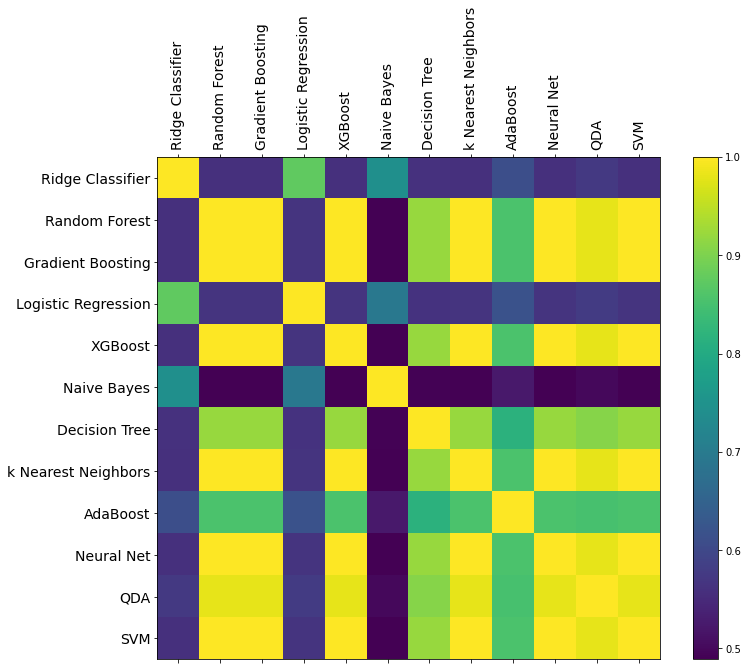

In [27]:
f = plt.figure(figsize=(12,9))
plt.matshow(preds_df.corr(), fignum=f.number)
plt.xticks(range(0, preds_df.columns.shape[0]), preds_df.columns, fontsize=14, rotation=90)
plt.yticks(range(0, preds_df.columns.shape[0]), preds_df.columns, fontsize=14)
cb = plt.colorbar()

# Stacking

We will perform 2 stackings:  on all models and the least correlated models.

     Ridge Classifier, Logistic Regression, Naive Bayes, KNN, Neural Net, AdaBoost, Decision Tree, XGBoost
     
We will cross validate Stacking with 4 folds:

    20% of fold validation
    2/3 of remaining fold for base models training
    1/3 of remaining fold for meta model training

In [28]:
folds = []
for train_index, test_index in ts_cv.split(X_std.iloc[:-10000]):
    X_fold = X_std.iloc[np.hstack((train_index, test_index))]
    y_fold = y[np.hstack((train_index, test_index))]
    folds.append((X_fold, y_fold))
print()

In [29]:
meta_model = XGBClassifier(use_label_encoder=False, eval_metric='rmse')
base_models_1 = {
    'Ridge Classifier' : best_models['Ridge Classifier'],
    'Random Forest' : best_models['Random Forest'],
    'Gradient Boosting' : best_models['Gradient Boosting'],
    'Logistic Regression' : best_models['Logistic Regression'],
    'XGBoost': best_models['XGBoost'],
    'Naive Bayes' : best_models['Naive Bayes'],
    'Decision Tree' : best_models['Decision Tree'],
    'k Nearest Neighbors' : best_models['k Nearest Neighbors'],
    'AdaBoost' : best_models['AdaBoost'],
    'Neural Net' :  best_models['Neural Net'],
    "QDA" : best_models['QDA'],
    "SVM" : best_models['SVM'],
}

In [30]:
base_models_2 = {
    'Ridge Classifier' : best_models['Ridge Classifier'],
    'Logistic Regression' : best_models['Logistic Regression'],
    'XGBoost': best_models['XGBoost'],
    'Naive Bayes' : best_models['Naive Bayes'],
    'Decision Tree' : best_models['Decision Tree'],
    'k Nearest Neighbors' : best_models['k Nearest Neighbors'],
    'AdaBoost' : best_models['AdaBoost'],
    'Neural Net' :  best_models['Neural Net'],
}


In [37]:
s = open("Pred_result.txt","w")
def save_predictor(pred):
    s.write(str(pred))

In [65]:
def fold_scoring(X, y, meta_model, base_models, return_meta_args=False):
    # accuracy of models
    df_acc = pd.DataFrame(columns=base_models.keys()) # Columns of DF will accord with base_dict keys
    
    # model predictions for the meta model
    train_predictions = {}
    val_predictions = {}
    
    # Split the data length into 2/3 base-training data and 1/3 meta-training data
    
    n_valid = round(X.shape[0] * 0.2)
    n_models = X.shape[0] - n_valid # n_valid is given as per above
    n_meta = round(n_models/3) # data size for meta model
    n_base = n_models - n_meta # data size for base models
    
    X_base = X.iloc[:n_base,:]
    X_meta = X.iloc[n_base:(n_base + n_meta),:]
    X_valid = X.iloc[n_models:(n_models + n_valid),:]
    
    y_base = y[:n_base]
    y_meta = y[n_base:(n_base + n_meta)]
    y_valid = y[n_models:(n_models + n_valid)]
    
    # Fit the base models to the base-training set, and generate predictions
    for name, clf in base_models.items():
        clf.fit(X_base, y_base)
        
        pred_meta = list(clf.predict(X_meta)) # Generate predictions on meta-training set
        train_predictions[name] = pred_meta # Append predictions to dictionary
        
        pred_valid = list(clf.predict(X_valid)) # Generate predictions on validation set for meta model
        val_predictions[name] = pred_valid
        save_predictor(pred_valid)
        df_acc[name] = pd.Series(round(accuracy_score(pred_valid, y_valid), 5)) # save score of classifier
    
    # Transform dictionary of predictions for meta model into DataFrames        
    df_meta_train = pd.DataFrame(train_predictions)
    df_meta_valid = pd.DataFrame(val_predictions)
    
    # Train meta model using base models' predictions of meta-training set
    meta_model.fit(df_meta_train, y_meta)
    
    # Generate meta model predictions of validation set
    meta_predictions = meta_model.predict(df_meta_valid)  
    save_predictor(meta_predictions)
    
    df_acc['Stack Model'] = pd.Series(round(accuracy_score(meta_predictions, y_valid), 5)) # save score of Stack Model
    if return_meta_args:
        return df_acc, df_meta_train, y_meta, df_meta_valid, y_valid
    return df_acc

In [ ]:
folds_res_1 = []
for i,f in enumerate(folds):
    print(f'Evaluating fold {i + 1}...')
    folds_res_1.append(fold_scoring(*f, meta_model, base_models_1))

Evaluating fold 1...


/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Evaluating fold 2...


/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/krzysztof/.local/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Evaluating fold 3...


In [40]:
acc_df_1 = pd.DataFrame(pd.concat(folds_res_1).mean(), columns = ['CV accuracy'])
acc_df_1['Classifier'] = acc_df_1.index
acc_df_1 = acc_df_1.sort_values(by=['CV accuracy'])
acc_df_1

,CV accuracy,Classifier
k Nearest Neighbors,0.723020,k Nearest Neighbors
Naive Bayes,0.760678,Naive Bayes
Logistic Regression,0.782290,Logistic Regression
Ridge Classifier,0.783490,Ridge Classifier
Decision Tree,0.790468,Decision Tree
AdaBoost,0.806513,AdaBoost
SVM,0.808283,SVM
Random Forest,0.859115,Random Forest
Gradient Boosting,0.888648,Gradient Boosting
Neural Net,0.891250,Neural Net


<AxesSubplot:xlabel='Classifier'>

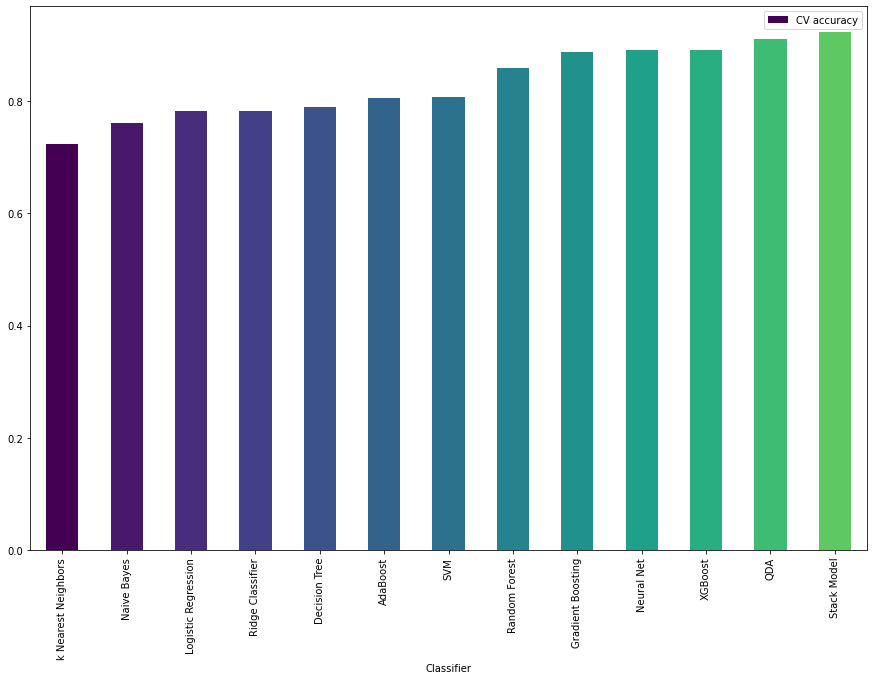

In [41]:
v = cm.get_cmap('viridis')
colors = v(np.linspace(0, 1, acc_df_1.shape[0] + 4))
fig, ax0 = plt.subplots(figsize=(15, 10))
acc_df_1.plot.bar(x = 'Classifier', y='CV accuracy', raterate

In [ ]:
folds_res_2 = []
for i,f in enumerate(folds):
    print(f'Evaluating fold {i + 1}...')
    folds_res_2.append(fold_scoring(*f, meta_model, base_models_2))

In [62]:
acc_df_2 = pd.DataFrame(pd.concat(folds_res_2).mean(), columns = ['CV accuracy'])
acc_df_2['Classifier'] = acc_df_2.index
acc_df_2 = acc_df_2.sort_values(by=['CV accuracy'])
acc_df_2

NameError: name 'folds_res_2' is not defined

In [63]:
v = cm.get_cmap('PuBuGn_r')
colors = v(np.linspace(0, 1, acc_df_2.shape[0] + 4))
fig, ax0 = plt.subplots(figsize=(15, 10))
acc_df_2.plot.bar(x = 'Classifier', y='CV accuracy', ax = ax0, color = colors)

NameError: name 'acc_df_2' is not defined

In [64]:
s_2 = open("True_result.txt","w")
s_2.write(str(list(y)))

146133

In [59]:
print(len(y))

48711
